In [30]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_log_error

from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [4]:
class TargetOrderEncode:
    def __init__(self):
        pass
    
    def fit_and_transform(self, train, feature):
        self.feature = feature
        self.ordering = pd.DataFrame()
        self.ordering['val'] = train[feature].unique()
        self.ordering.index = self.ordering.val
        self.ordering['spmean'] = train[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
        self.ordering = self.ordering.sort_values('spmean')
        self.ordering['ordering'] = range(1, self.ordering.shape[0]+1)
        self.ordering = self.ordering['ordering'].to_dict()

        self.transform(train)

    def transform(self, test):
        for cat, o in self.ordering.items():
            test.loc[test[self.feature] == cat, self.feature+'_E'] = o

In [5]:
qual_encoded = []
for q in qualitative:
    encoder = TargetOrderEncode()
    encoder.fit_and_transform(train, q)
    encoder.transform(test)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [6]:
log_features = [
    'GrLivArea',
    '1stFlrSF',
    '2ndFlrSF',
    'TotalBsmtSF',
    'LotArea',
    'LotFrontage',
    'KitchenAbvGr',
    'GarageArea'
]

quad_feats = [
    'OverallQual',
    'YearBuilt',
    'YearRemodAdd',
    'TotalBsmtSF',
    '2ndFlrSF',
    'Neighborhood_E',
    'RoofMatl_E',
    'GrLivArea'
]

qdr = [f+'2' for f in quad_feats]

In [7]:
def log_transform(df, feature):
    df[feature] = np.log1p(df[feature].values)

def quadratic(df, feature):
    df[feature+'2'] = df[feature]**2

def bool_encode(train):
    train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
    train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
    train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
    train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

In [8]:
for f in quad_feats:
    quadratic(train, f)
    quadratic(test, f)

for f in log_features:
    log_transform(train, f)
    log_transform(test, f)

bool_encode(train)
bool_encode(test)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']

features = quantitative + qual_encoded + boolean + qdr

In [9]:
def error(actual, predicted):
    return np.sqrt(mean_squared_log_error(actual, predicted))

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=216)

## Ridge

In [11]:
X = train[features].fillna(0.).values
Y = train['SalePrice'].values

models = []
Ypred = np.zeros_like(Y)

for train_index, val_index in kf.split(X):
    X_tr = X[train_index]
    X_val = X[val_index]
    y_tr = Y[train_index]
    y_val = Y[val_index]
    
    ridge = Ridge()
    ridge.fit(X_tr, np.log(y_tr))
    
    y_pred = np.exp(ridge.predict(X_val))
    Ypred[val_index] = y_pred
    
    print(error(y_val, y_pred))
    
    models.append(ridge)

0.11205509234113975
0.13071949887035056
0.1169484041791938
0.12753968125947115
0.11915025549134804


/home/ksaw/.cache/pypoetry/virtualenvs/house-price-PNXQfjFB-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.05281e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/ksaw/.cache/pypoetry/virtualenvs/house-price-PNXQfjFB-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.00631e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [12]:
error(Y, Ypred)

0.12147756793269066

In [13]:
submissions = pd.DataFrame()

submissions['Ridge'] = Ypred

## MLP

In [39]:
X = train[features].fillna(0.).values
Y = train['SalePrice'].values
X_test = test[features].fillna(0.).values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [40]:
input_dim = X.shape[1]

In [41]:
class MLPNet (nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)   
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.fc4 = nn.Linear(10, 1)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [42]:
# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [52]:
def train_model(train_loader, valid_loader):
    net = MLPNet().to(device)
 
    # optimizing
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    print ('training start ...')
    num_epochs = 500  

    # initialize list for plot graph after training
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):
        # initialize each epoch
        train_loss, val_loss = 0, 0

        # ======== train_mode ======
        net.train()
        for i, (x, labels) in enumerate(train_loader):  # ミニバッチ回数実行
            x, labels = x.to(device), labels.to(device)
            optimizer.zero_grad()  # 勾配リセット
            outputs = net(x)  # 順伝播の計算
            loss = criterion(torch.flatten(outputs), labels)  # lossの計算
            train_loss += loss.item()  # train_loss に結果を蓄積
            loss.backward()  # 逆伝播の計算        
            optimizer.step()  # 重みの更新
            avg_train_loss = np.sqrt(train_loss / len(train_loader.dataset))  # lossの平均を計算

        # ======== valid_mode ======
        net.eval()
        with torch.no_grad():  # 必要のない計算を停止
            for x, labels in valid_loader:        
                x, labels = x.to(device), labels.to(device)
                outputs = net(x)
                loss = criterion(torch.flatten(outputs), labels)
                val_loss += loss.item()
        avg_val_loss = np.sqrt(val_loss / len(valid_loader.dataset))

        # print log
        if epoch % 10 == 0:
            print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}' 
                           .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss))

        # append list for polt graph after training
        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
               
    return net

In [53]:
def get_loader(X, Y, shuffle=True):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    
    dataset = torch.utils.data.TensorDataset(X, Y)

    loader = torch.utils.data.DataLoader(
        dataset=dataset,  # データセットの指定
        batch_size=64,  # ミニバッチの指定
        shuffle=True,  # シャッフルするかどうかの指定
        num_workers=2)  # コアの数
    return loader

In [54]:
models = []
Ypred = np.zeros_like(Y)

for i, (train_index, val_index) in enumerate(kf.split(X)):
    X_tr = X[train_index]
    X_val = X[val_index]
    y_tr = Y[train_index]
    y_val = Y[val_index]

    train_loader = get_loader(X_tr, np.log(y_tr))
    valid_loader = get_loader(X_val, np.log(y_val))
    
    model = train_model(train_loader, valid_loader)
    models.append(model)

    model.eval()
    with torch.no_grad():
        y_pred = np.exp(model(torch.tensor(X_val).float().to(device)))
        Ypred[val_index] = y_pred.flatten()
    
    print(error(y_val, y_pred))
    
    models.append(model)

training start ...
Epoch [1/500], Loss: 0.7610, val_loss: 0.3881
Epoch [11/500], Loss: 0.1439, val_loss: 0.1263
Epoch [21/500], Loss: 0.1076, val_loss: 0.0895
Epoch [31/500], Loss: 0.1117, val_loss: 0.1062
Epoch [41/500], Loss: 0.1146, val_loss: 0.0910
Epoch [51/500], Loss: 0.1003, val_loss: 0.0843
Epoch [61/500], Loss: 0.1012, val_loss: 0.0766
Epoch [71/500], Loss: 0.0959, val_loss: 0.1011
Epoch [81/500], Loss: 0.0970, val_loss: 0.0969
Epoch [91/500], Loss: 0.1019, val_loss: 0.0939
Epoch [101/500], Loss: 0.0940, val_loss: 0.0892
Epoch [111/500], Loss: 0.0861, val_loss: 0.0811
Epoch [121/500], Loss: 0.0854, val_loss: 0.0896
Epoch [131/500], Loss: 0.0867, val_loss: 0.1049
Epoch [141/500], Loss: 0.0807, val_loss: 0.0749
Epoch [151/500], Loss: 0.1021, val_loss: 0.1029
Epoch [161/500], Loss: 0.0737, val_loss: 0.0635
Epoch [171/500], Loss: 0.0686, val_loss: 0.0842
Epoch [181/500], Loss: 0.0666, val_loss: 0.0603
Epoch [191/500], Loss: 0.0661, val_loss: 0.1002
Epoch [201/500], Loss: 0.0776, v

In [55]:
error(Y, Ypred)

0.22187952063239444

In [57]:
submissions['MLP'] = Ypred

## モデルの相関

In [58]:
import seaborn as sns

<AxesSubplot:>

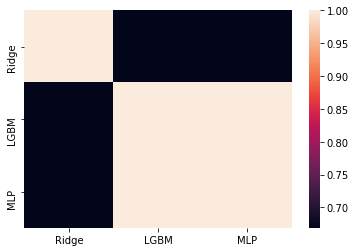

In [59]:
corr = submissions.corr()
sns.heatmap(corr)

## Submission

In [ ]:
X_test = test[features].fillna(0.).values

In [ ]:
test_preds = []

for m in models:
    test_pred = np.exp(m.predict(X_test))
    test_preds.append(test_pred)

test_preds = np.vstack(test_preds).mean(axis=0)

In [ ]:
submission = test[['Id']]

In [ ]:
submission['SalePrice'] = test_preds

In [ ]:
submission

In [ ]:
submission.to_csv('../output/base_line.csv', index=False)